In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from IPython.display import display
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix,recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



In [2]:
df=pd.read_csv("telecom_customer_churn.csv")
dic = pd.read_csv("telecom_data_dictionary.csv", encoding='latin1')
print(df.shape)
df.head()


(7043, 38)


Customer ID  Gender  Age Married  Number of Dependents          City  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3  0011-IGKFF    Male   78     Yes                     0      Martinez   
4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   

   Zip Code   Latitude   Longitude  Number of Referrals  Tenure in Months  \
0     93225  34.827662 -118.999073                    2                 9   
1     91206  34.162515 -118.203869                    0                 9   
2     92627  33.645672 -117.922613                    0                 4   
3     94553  38.014457 -122.115432                    1                13   
4     93010  34.227846 -119.079903                    3                 3   

     Offer Phone Service  Avg Monthly Long Distance Charges Multiple Lines  \
0      NaN           Yes                              42.39             No   
1      NaN           Yes                              10.69            Yes   
2  Offer E           Yes                              33.65             No   
3  Offer D           Yes                              27.82             No   
4      NaN           Yes                               7.38             No   

  Internet Service Internet Type  Avg Monthly GB Download Online Security  \
0              Yes         Cable                     16.0              No   
1              Yes         Cable                     10.0              No   
2              Yes   Fiber Optic                     30.0              No   
3              Yes   Fiber Optic                      4.0              No   
4              Yes   Fiber Optic                     11.0              No   

  Online Backup Device Protection Plan Premium Tech Support Streaming TV  \
0           Yes                     No                  Yes          Yes   
1            No                     No                   No           No   
2            No                    Yes                   No           No   
3           Yes                    Yes                   No          Yes   
4            No                     No                  Yes          Yes   

  Streaming Movies Streaming Music Unlimited Data        Contract  \
0               No              No            Yes        One Year   
1              Yes             Yes             No  Month-to-Month   
2               No              No            Yes  Month-to-Month   
3              Yes              No            Yes  Month-to-Month   
4               No              No            Yes  Month-to-Month   

  Paperless Billing   Payment Method  Monthly Charge  Total Charges  \
0               Yes      Credit Card            65.6         593.30   
1                No      Credit Card            -4.0         542.40   
2               Yes  Bank Withdrawal            73.9         280.85   
3               Yes  Bank Withdrawal            98.0        1237.85   
4               Yes      Credit Card            83.9         267.40   

   Total Refunds  Total Extra Data Charges  Total Long Distance Charges  \
0           0.00                         0                       381.51   
1          38.33                        10                        96.21   
2           0.00                         0                       134.60   
3           0.00                         0                       361.66   
4           0.00                         0                        22.14   

   Total Revenue Customer Status   Churn Category  \
0         974.81          Stayed              NaN   
1         610.28          Stayed              NaN   
2         415.45         Churned       Competitor   
3        1599.51         Churned  Dissatisfaction   
4         289.54         Churned  Dissatisfaction   

                    Churn Reason  
0                            NaN  
1                      

In [3]:
for i in dic.index:
    print(dic["Field"][i])  
    print(dic["Description"][i])

CustomerID
A unique ID that identifies each customer
Gender
The customers gender: Male, Female
Age
The customers current age, in years, at the time the fiscal quarter ended (Q2 2022)
Married
Indicates if the customer is married: Yes, No
Number of Dependents
Indicates the number of dependents that live with the customer (dependents could be children, parents, grandparents, etc.)
City
The city of the customers primary residence in California
Zip Code
The zip code of the customers primary residence
Latitude
The latitude of the customers primary residence
Longitude
The longitude of the customers primary residence
Number of Referrals
Indicates the number of times the customer has referred a friend or family member to this company to date
Tenure in Months
Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above
Offer
Identifies the last marketing offer that the customer accepted: None, Offer A, Offer B, Offer C, Offer D,

distribution
Customer Status              
Churned                  1869
Joined                    454
Stayed                   4720

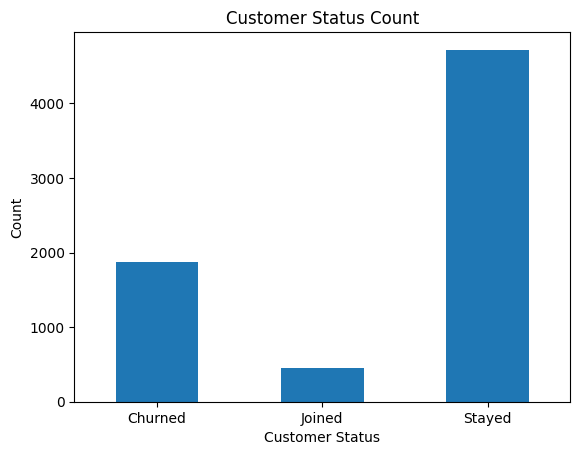

In [4]:
stat=df.groupby("Customer Status").count().iloc[:,0:1]
stat.columns = ["distribution"]
display(stat)
stat.plot(kind='bar', legend=False)
plt.title('Customer Status Count')
plt.xlabel('Customer Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

So we are dealing with an imbalanced dataset

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

In [6]:
df = df[df['Customer Status'] != 'Joined']
df['Customer Status'] = df['Customer Status'].map({'Churned': 1, 'Stayed': 0})


We dropped "Joined" because we are interesting only on "churned" or "stayed" customers

In [7]:
df= df.drop(columns=['Zip Code','City','Churn Category','Churn Reason','Latitude','Longitude','Customer ID'])


In [8]:
df['Offer'] = df['Offer'].fillna('no offer')
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(0)
df['Internet Type'] = df['Internet Type'].fillna('no internet')
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].fillna(0)
for c in ["Multiple Lines","Online Security","Online Backup","Device Protection Plan","Premium Tech Support","Streaming TV","Streaming Movies","Streaming Music","Unlimited Data"]:
    df[c]=df[c].fillna('No')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6589 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6589 non-null   object 
 1   Age                                6589 non-null   int64  
 2   Married                            6589 non-null   object 
 3   Number of Dependents               6589 non-null   int64  
 4   Number of Referrals                6589 non-null   int64  
 5   Tenure in Months                   6589 non-null   int64  
 6   Offer                              6589 non-null   object 
 7   Phone Service                      6589 non-null   object 
 8   Avg Monthly Long Distance Charges  6589 non-null   float64
 9   Multiple Lines                     6589 non-null   object 
 10  Internet Service                   6589 non-null   object 
 11  Internet Type                      6589 non-null   object 
 1

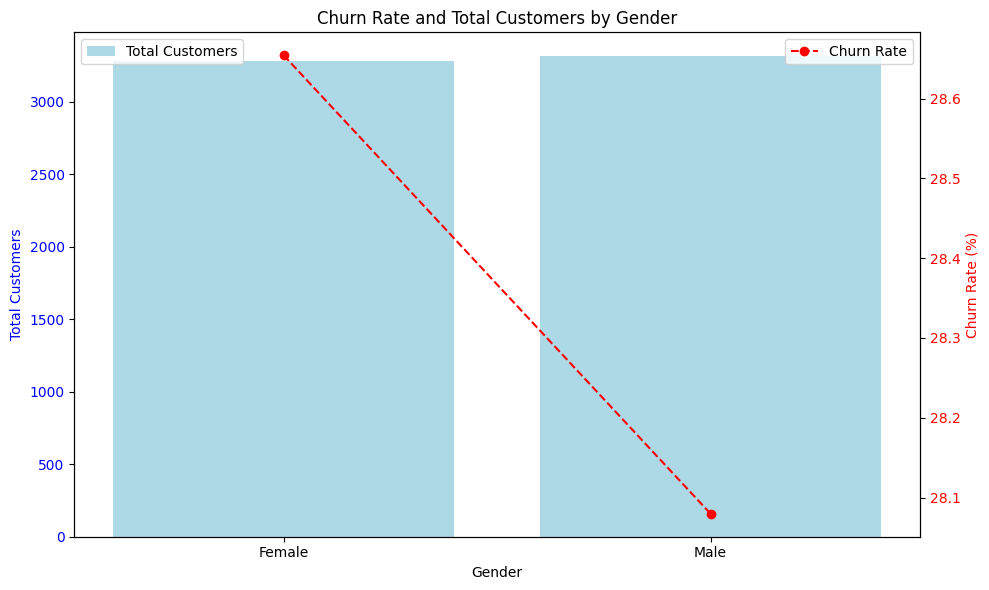

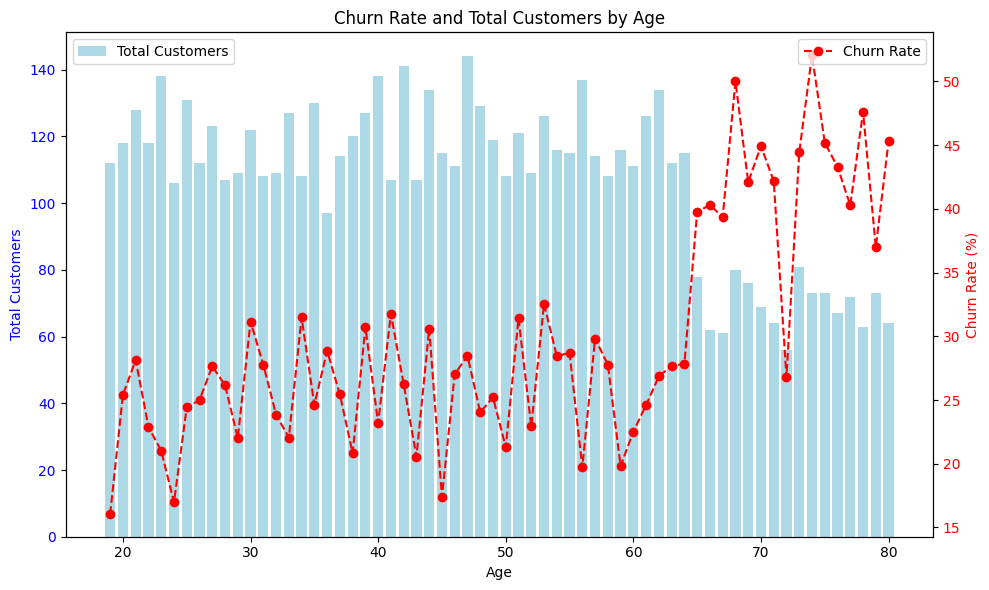

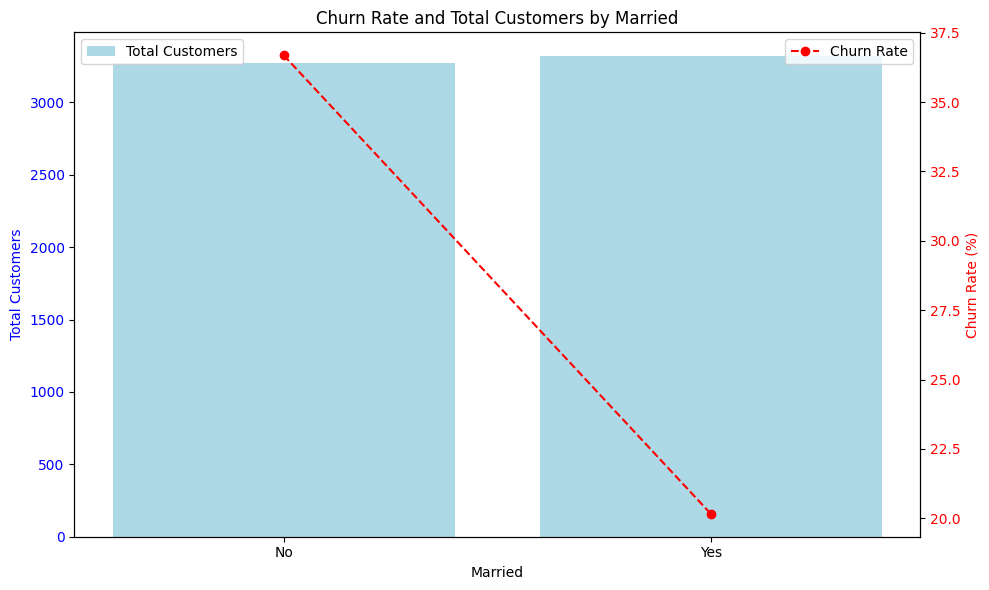

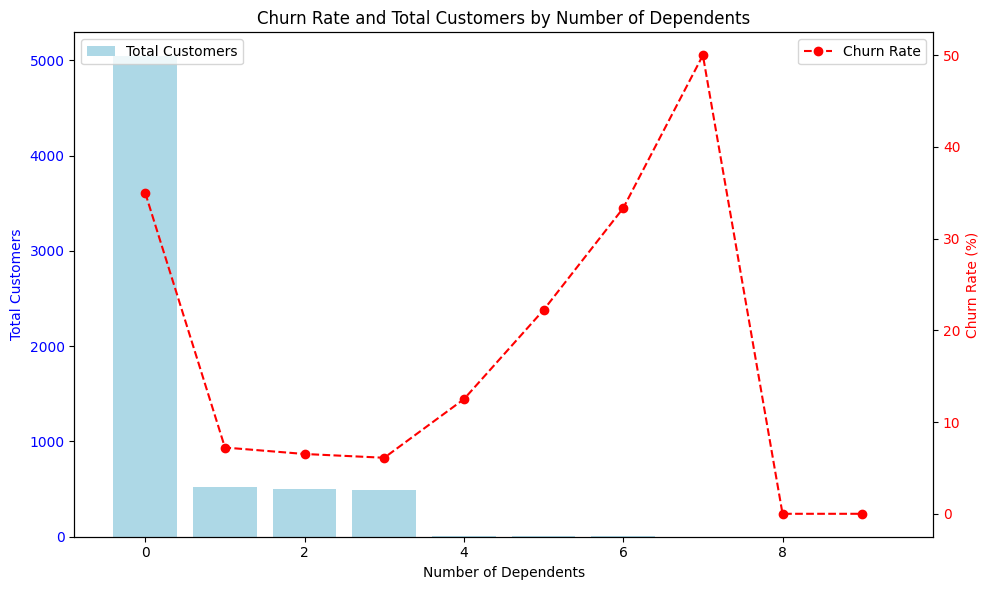

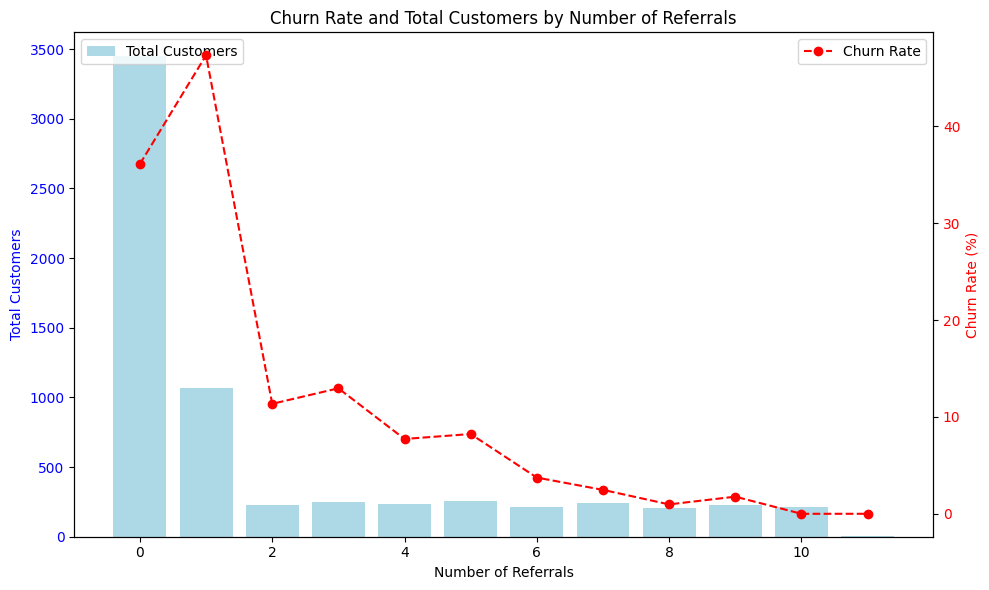

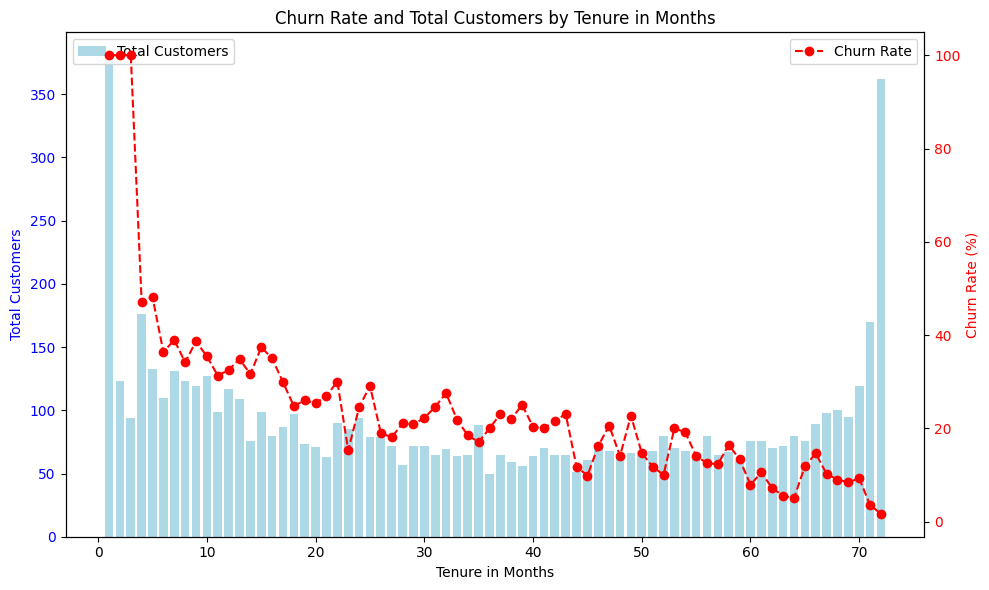

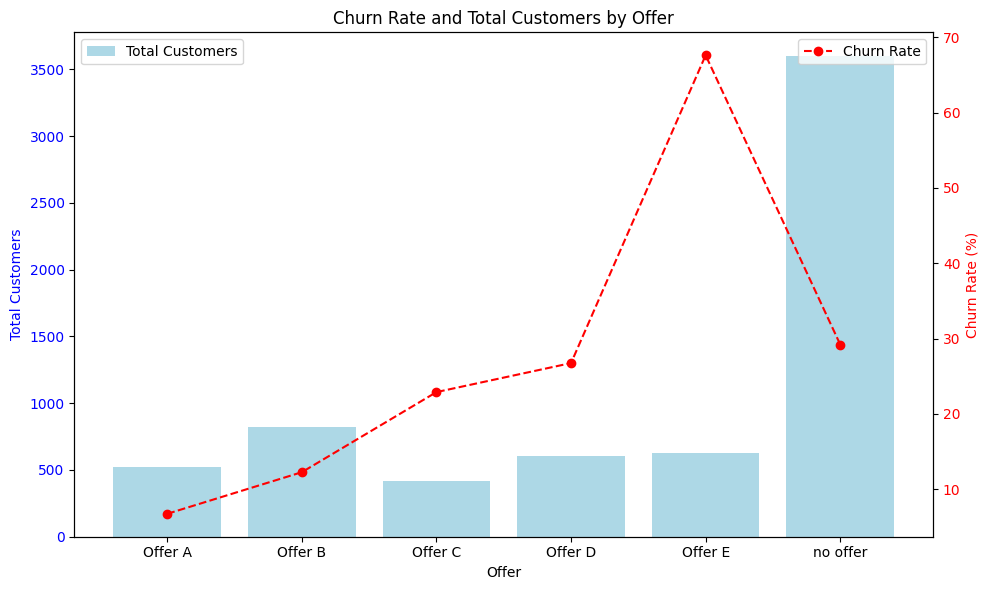

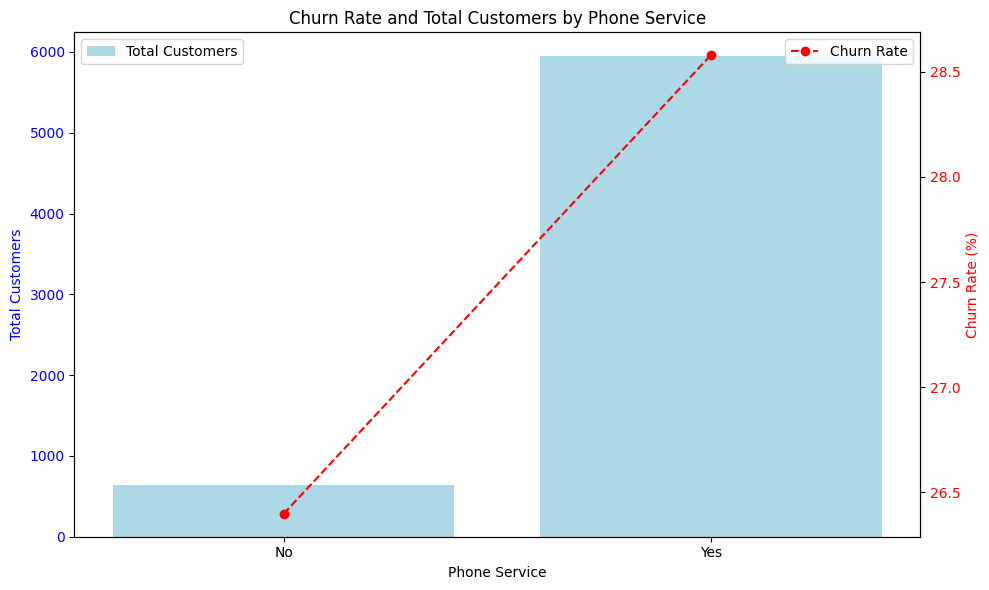

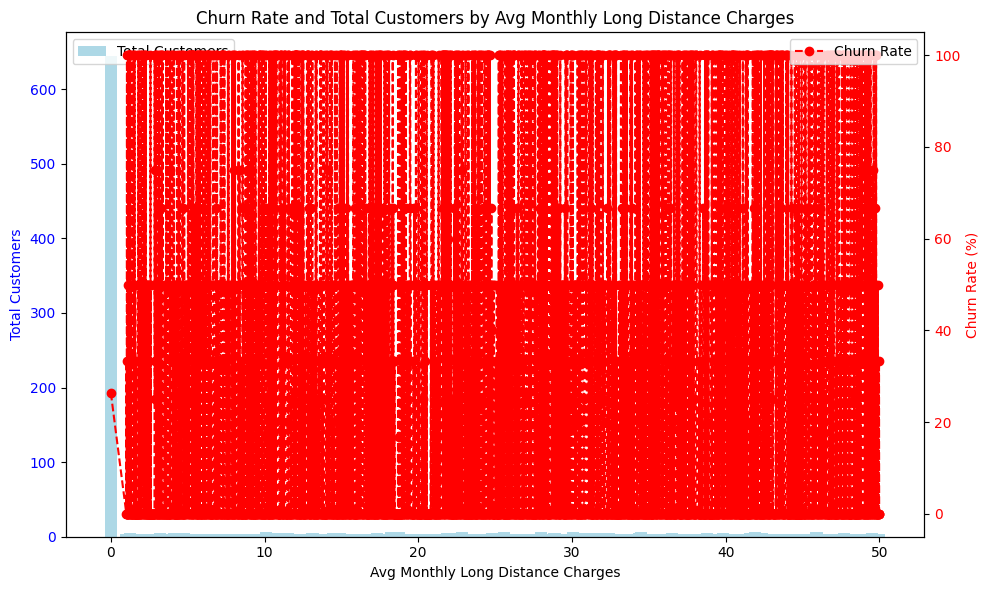

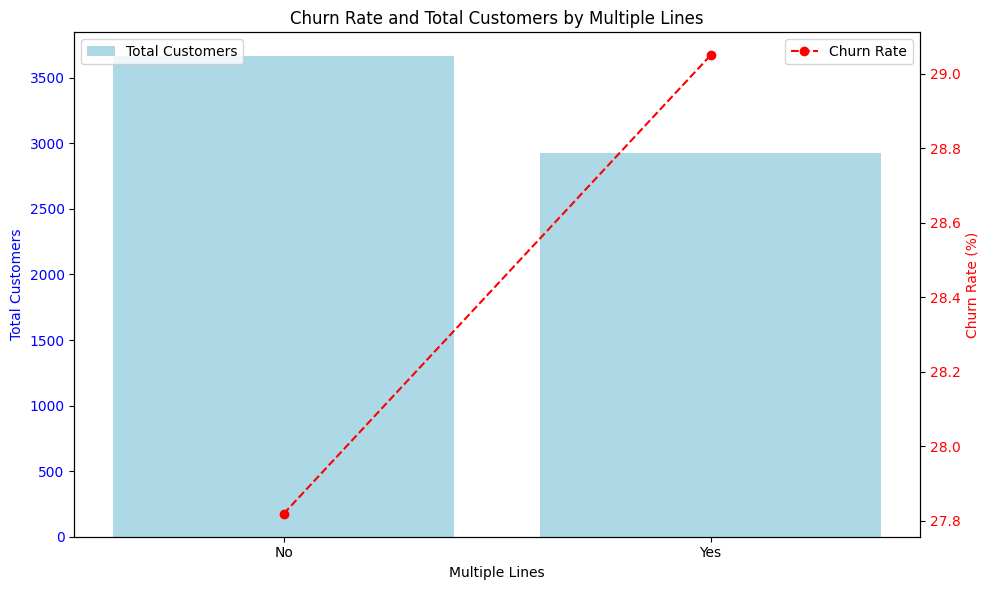

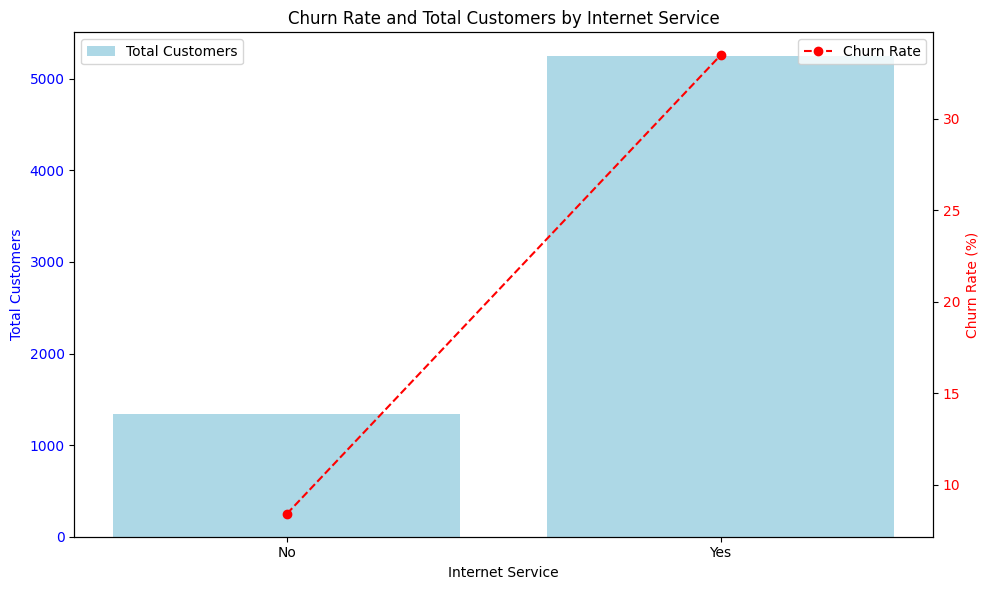

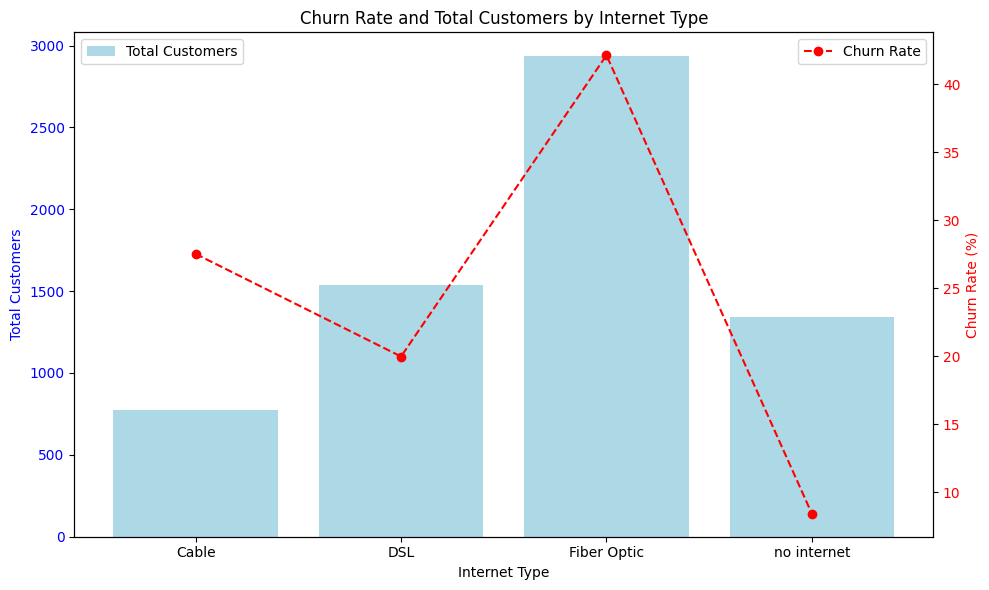

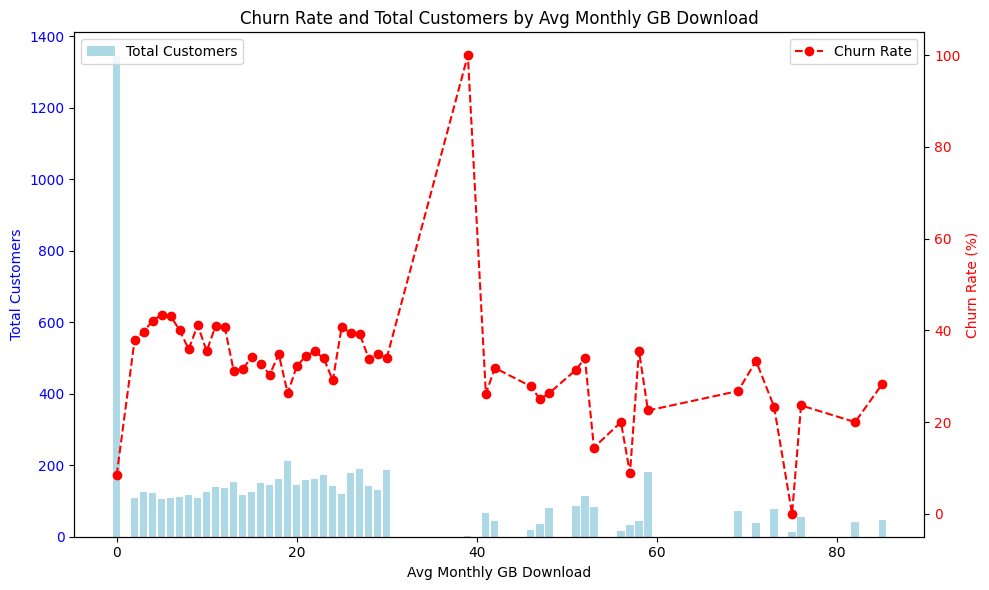

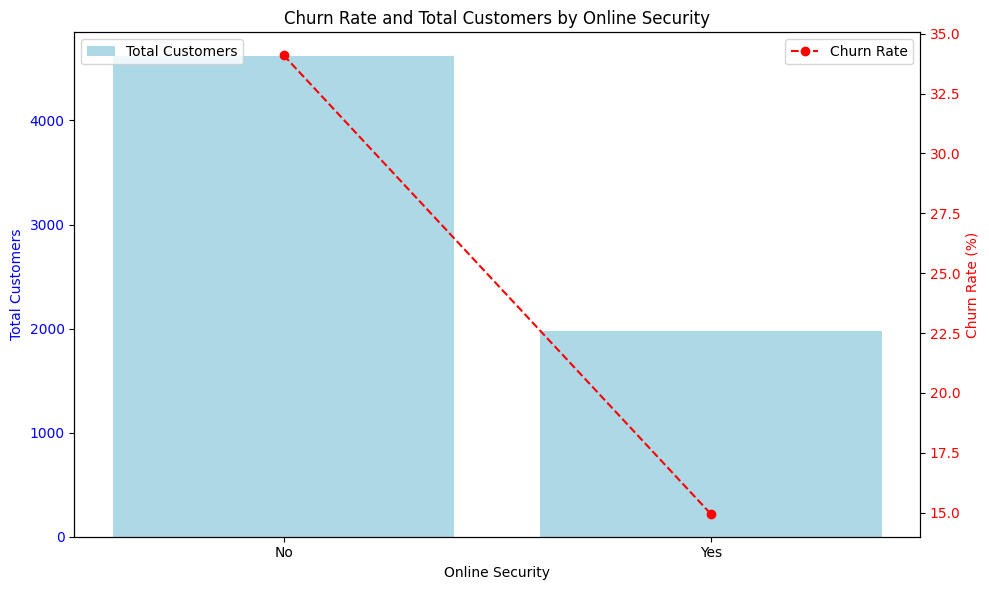

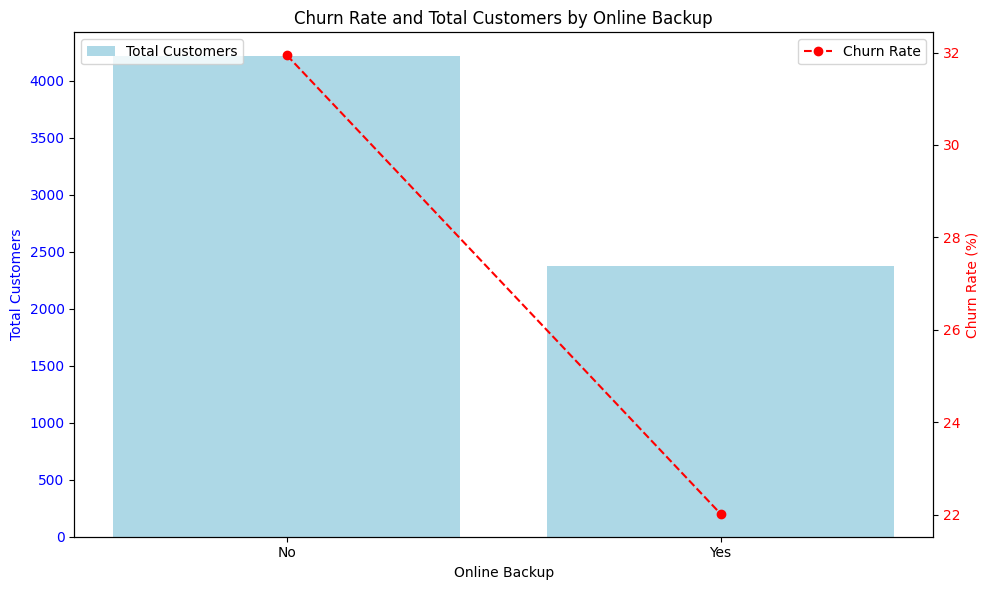

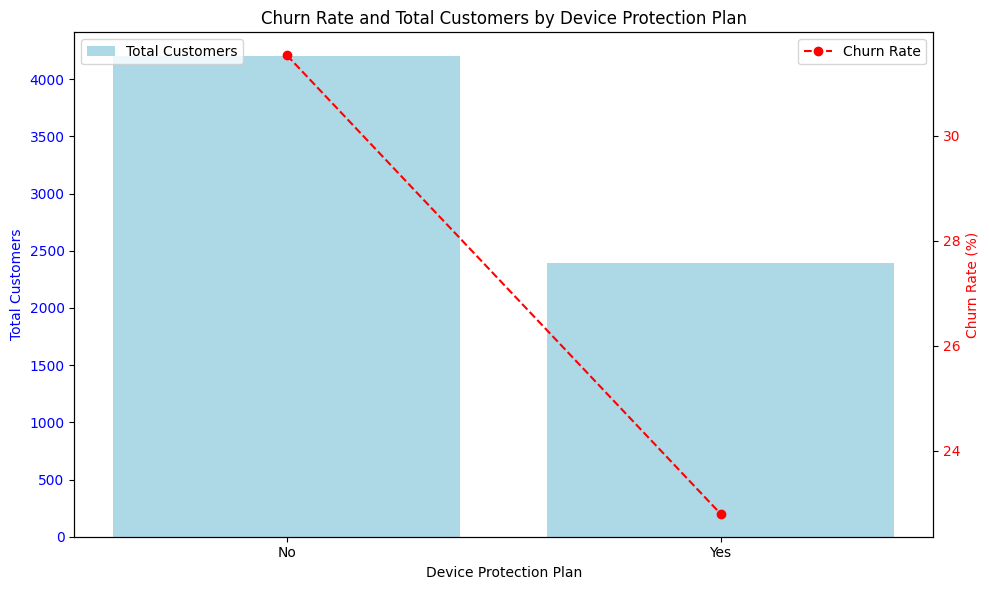

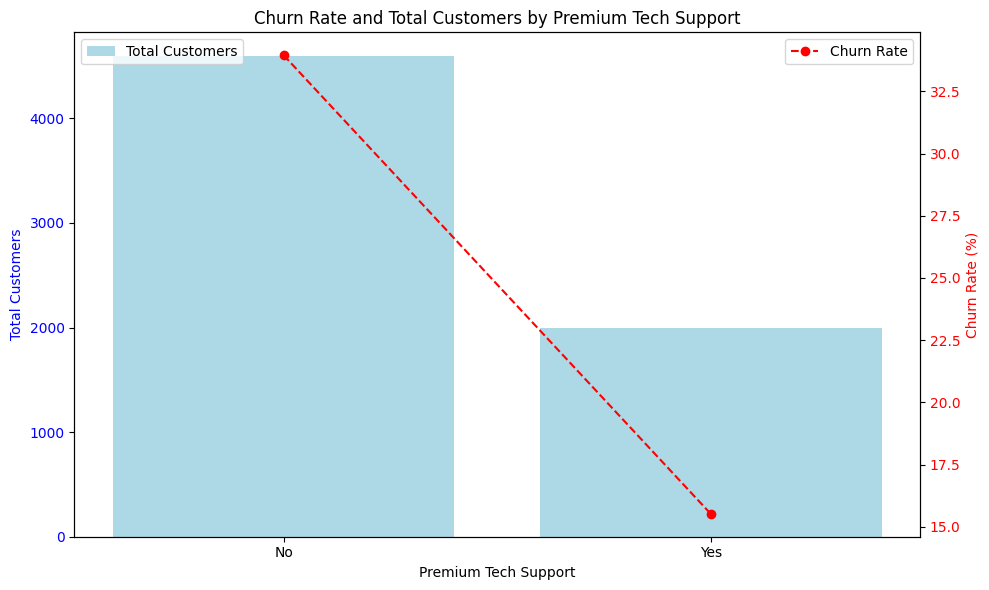

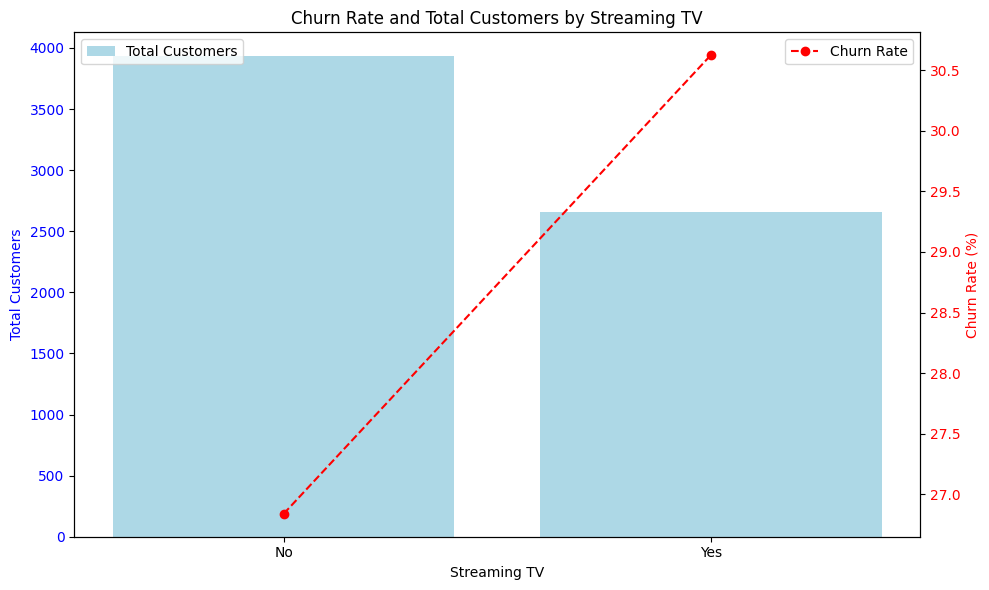

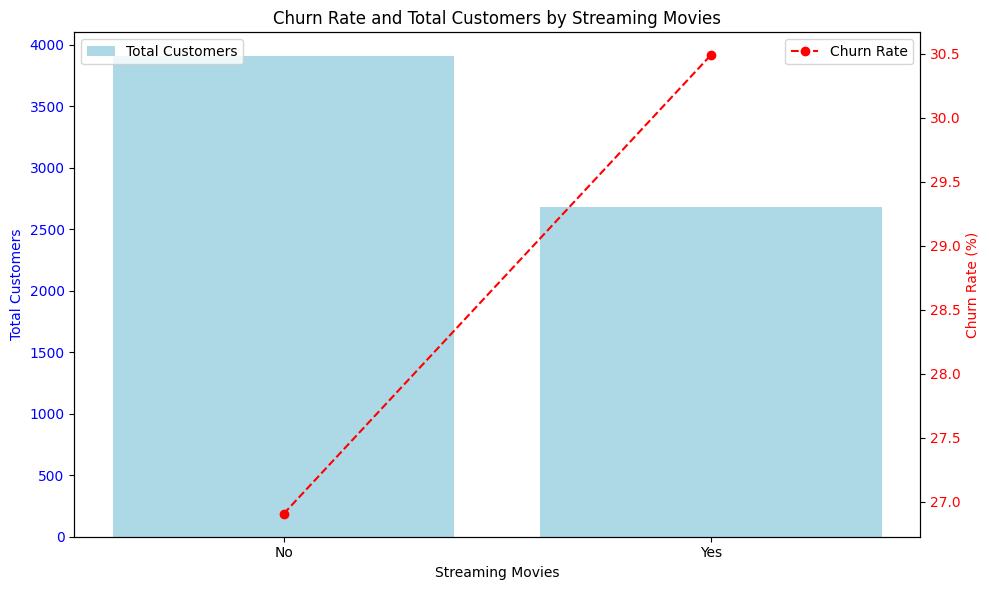

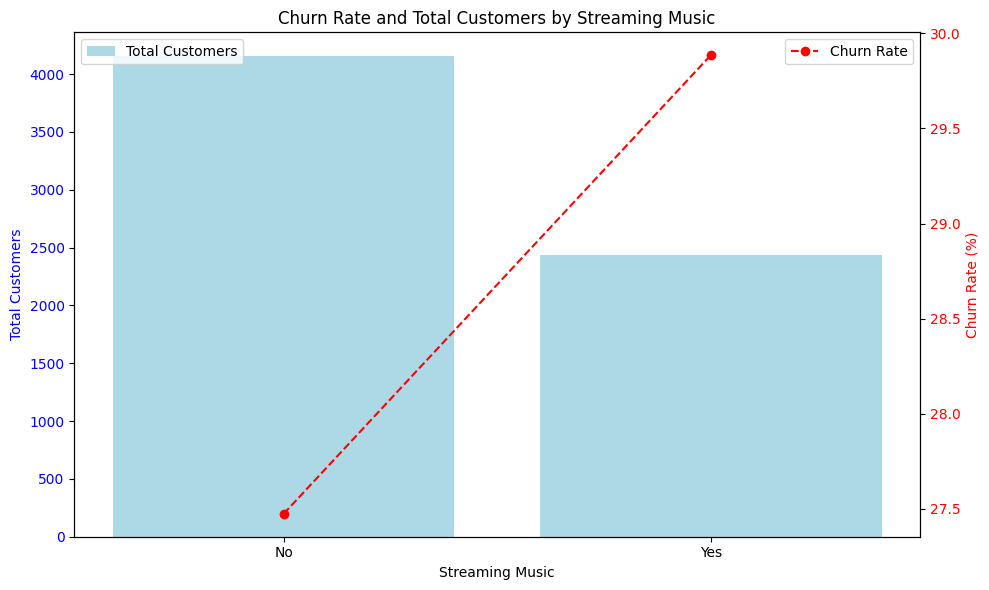

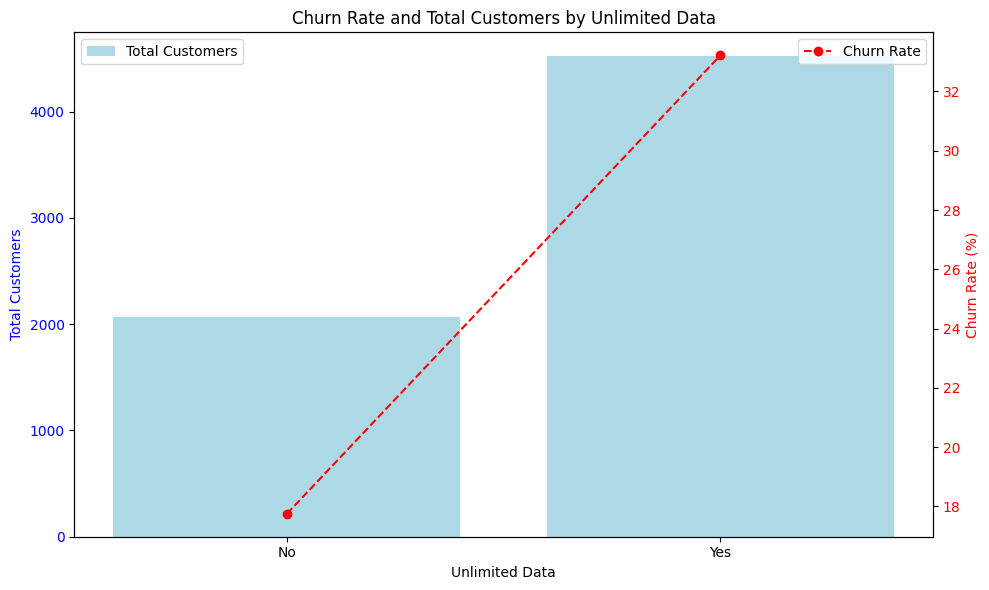

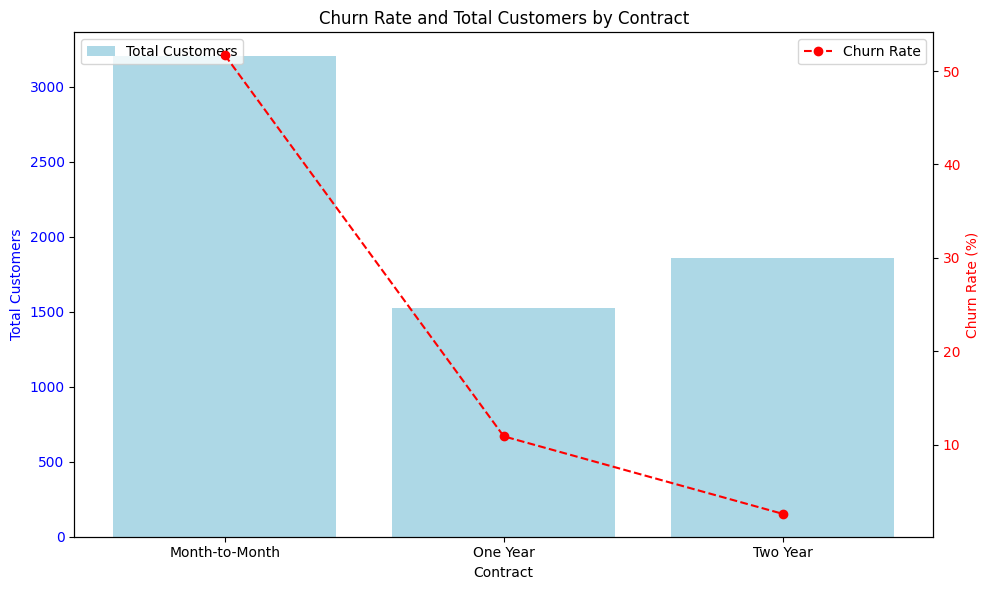

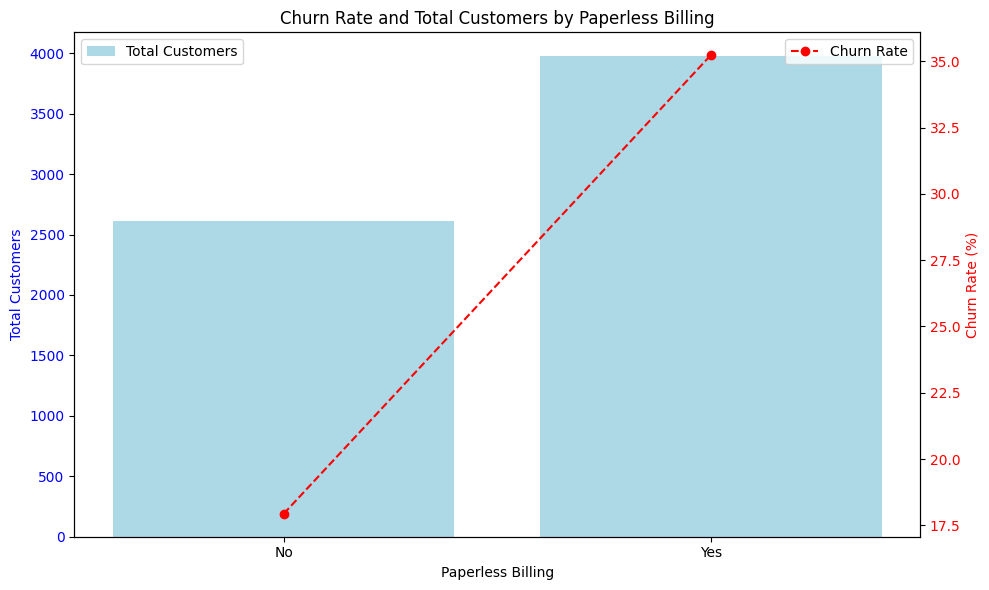

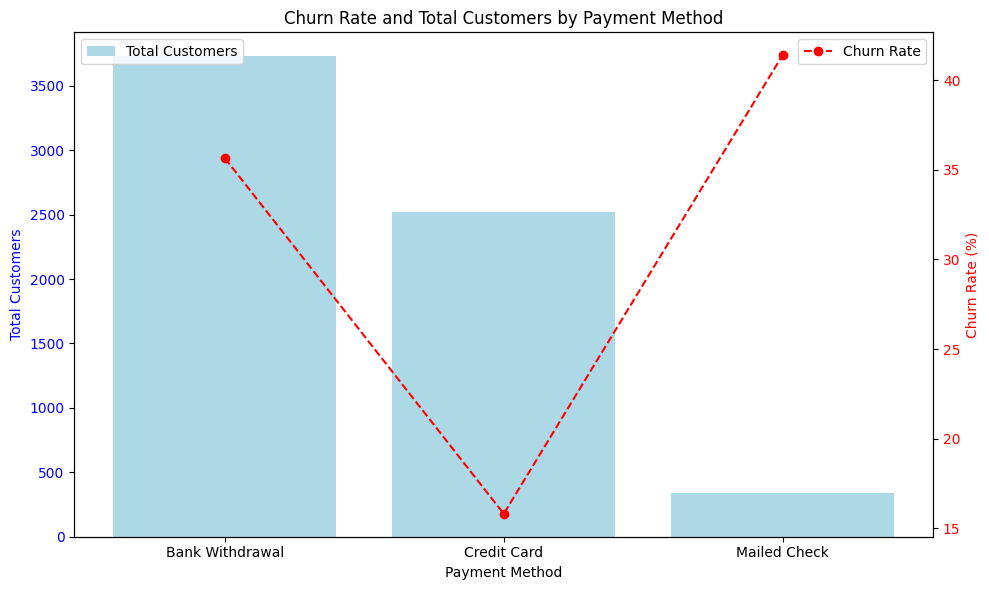

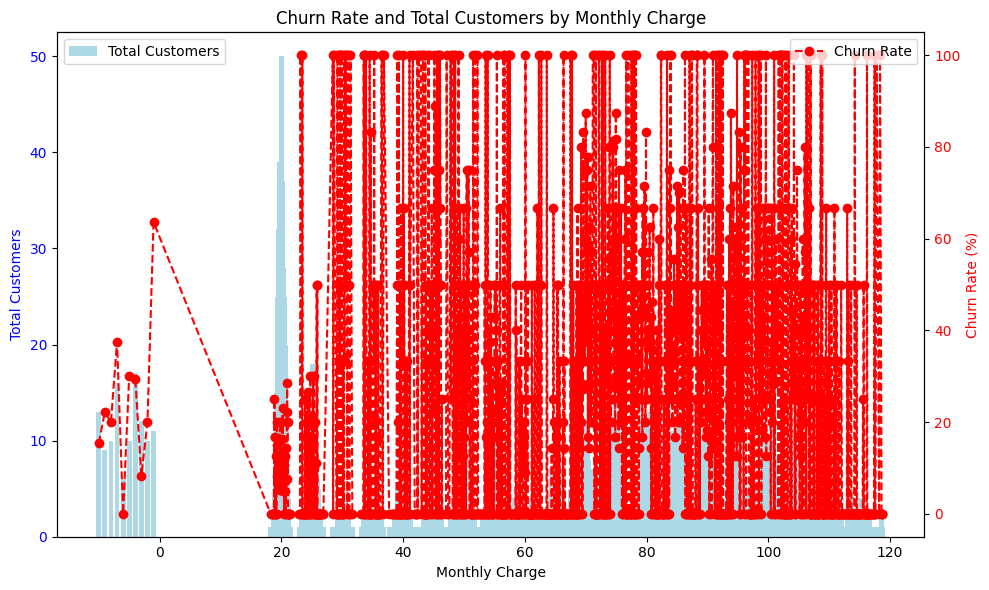

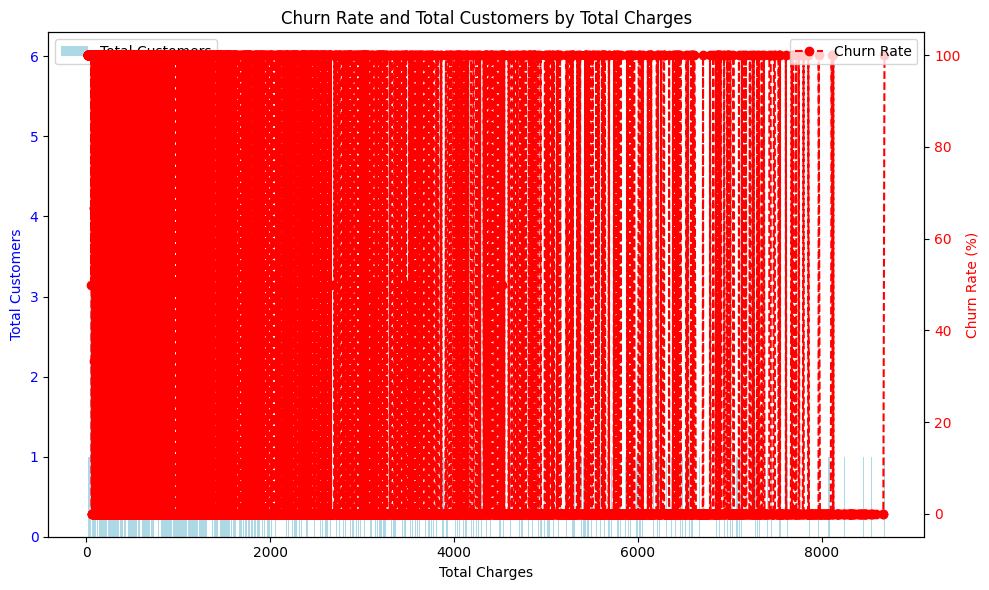

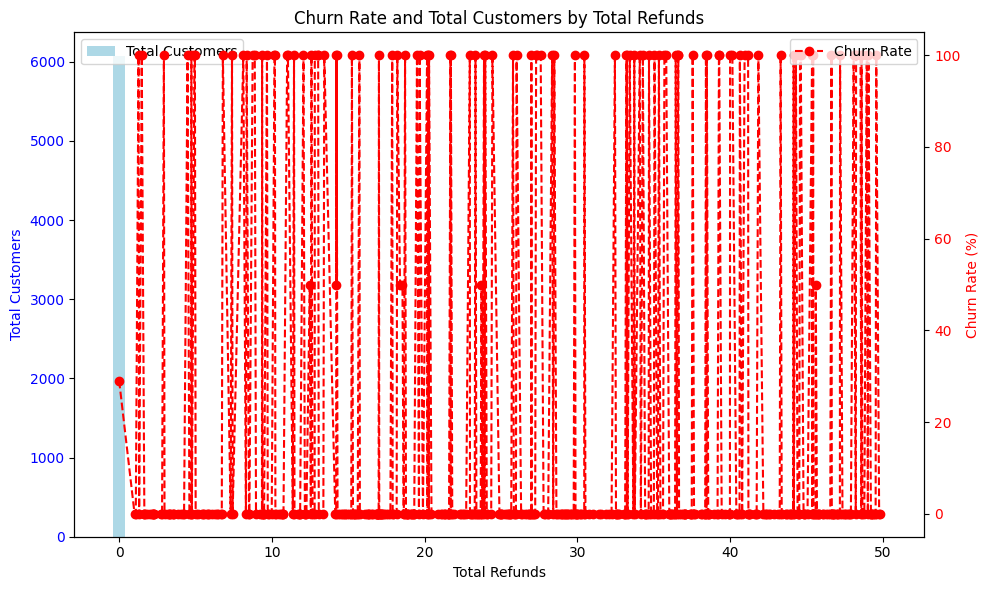

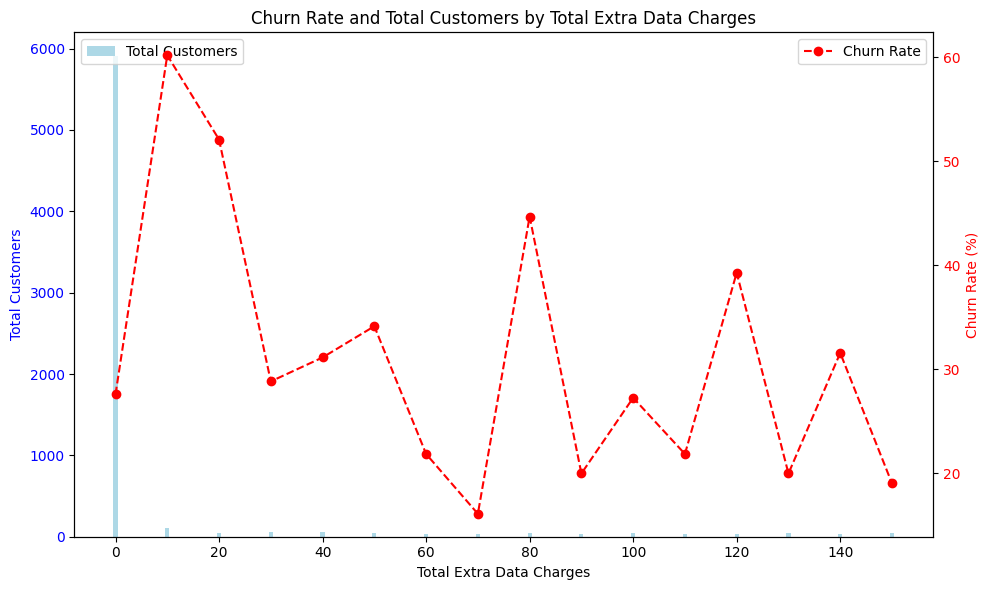

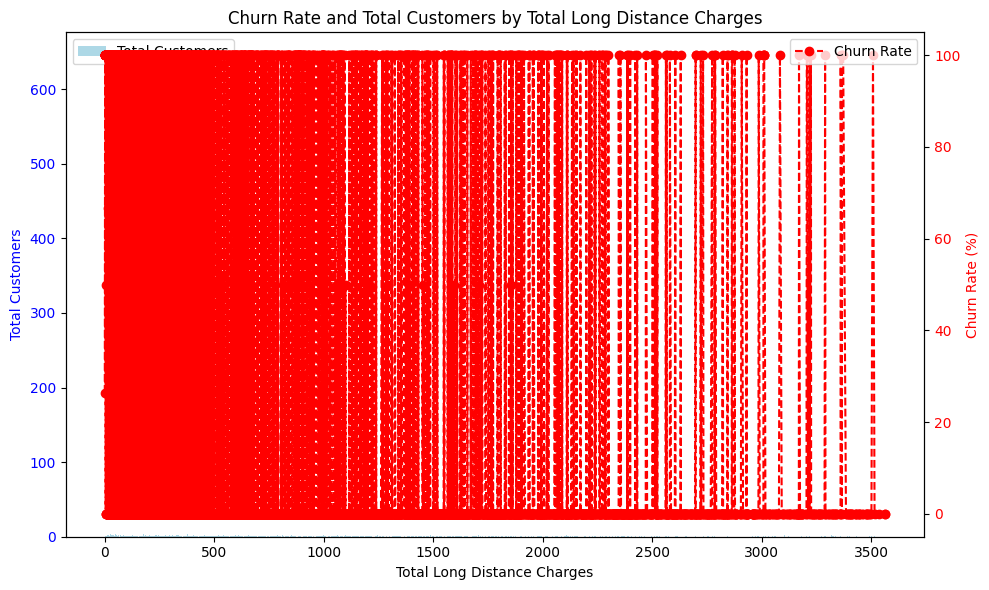

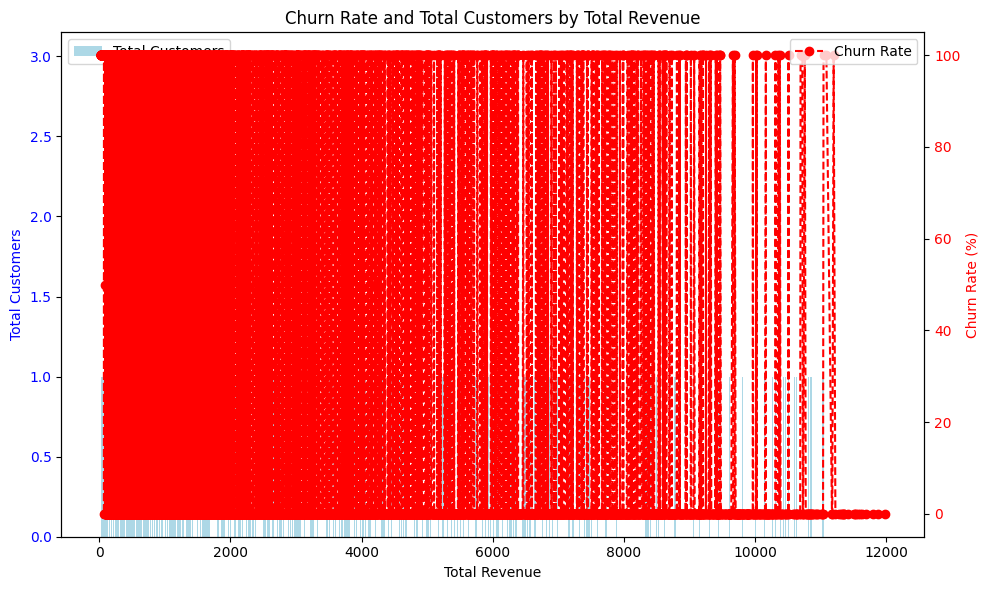

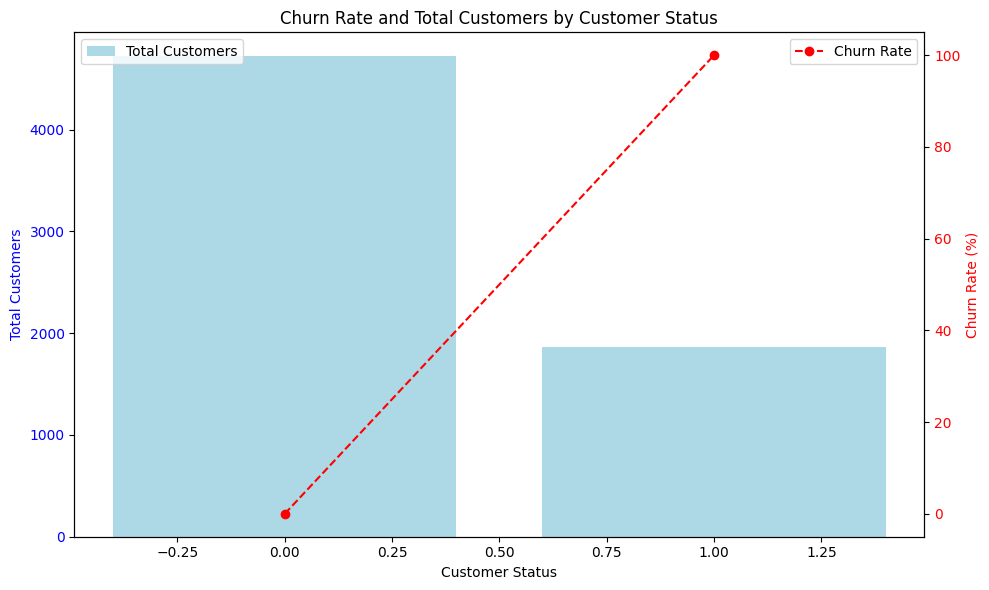

In [10]:
for i in df.columns:
    churn_rate = df.groupby(i)['Customer Status'].apply(lambda x: (x == 1).mean() * 100)

    total_customers = df.groupby(i).size()

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(total_customers.index, total_customers.values, color='lightblue', label='Total Customers')
    ax1.set_xlabel(i)
    ax1.set_ylabel('Total Customers', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(churn_rate.index, churn_rate.values, color='red', label='Churn Rate', marker='o', linestyle='--')
    ax2.set_ylabel('Churn Rate (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Churn Rate and Total Customers by {i}')

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


In [11]:
df= df.drop(columns=['Gender'])


In [12]:
features = df.drop('Customer Status', axis=1).columns
X = pd.get_dummies(df[features], drop_first=True,dtype=int)  # One-hot encode categorical variables
y = df['Customer Status']

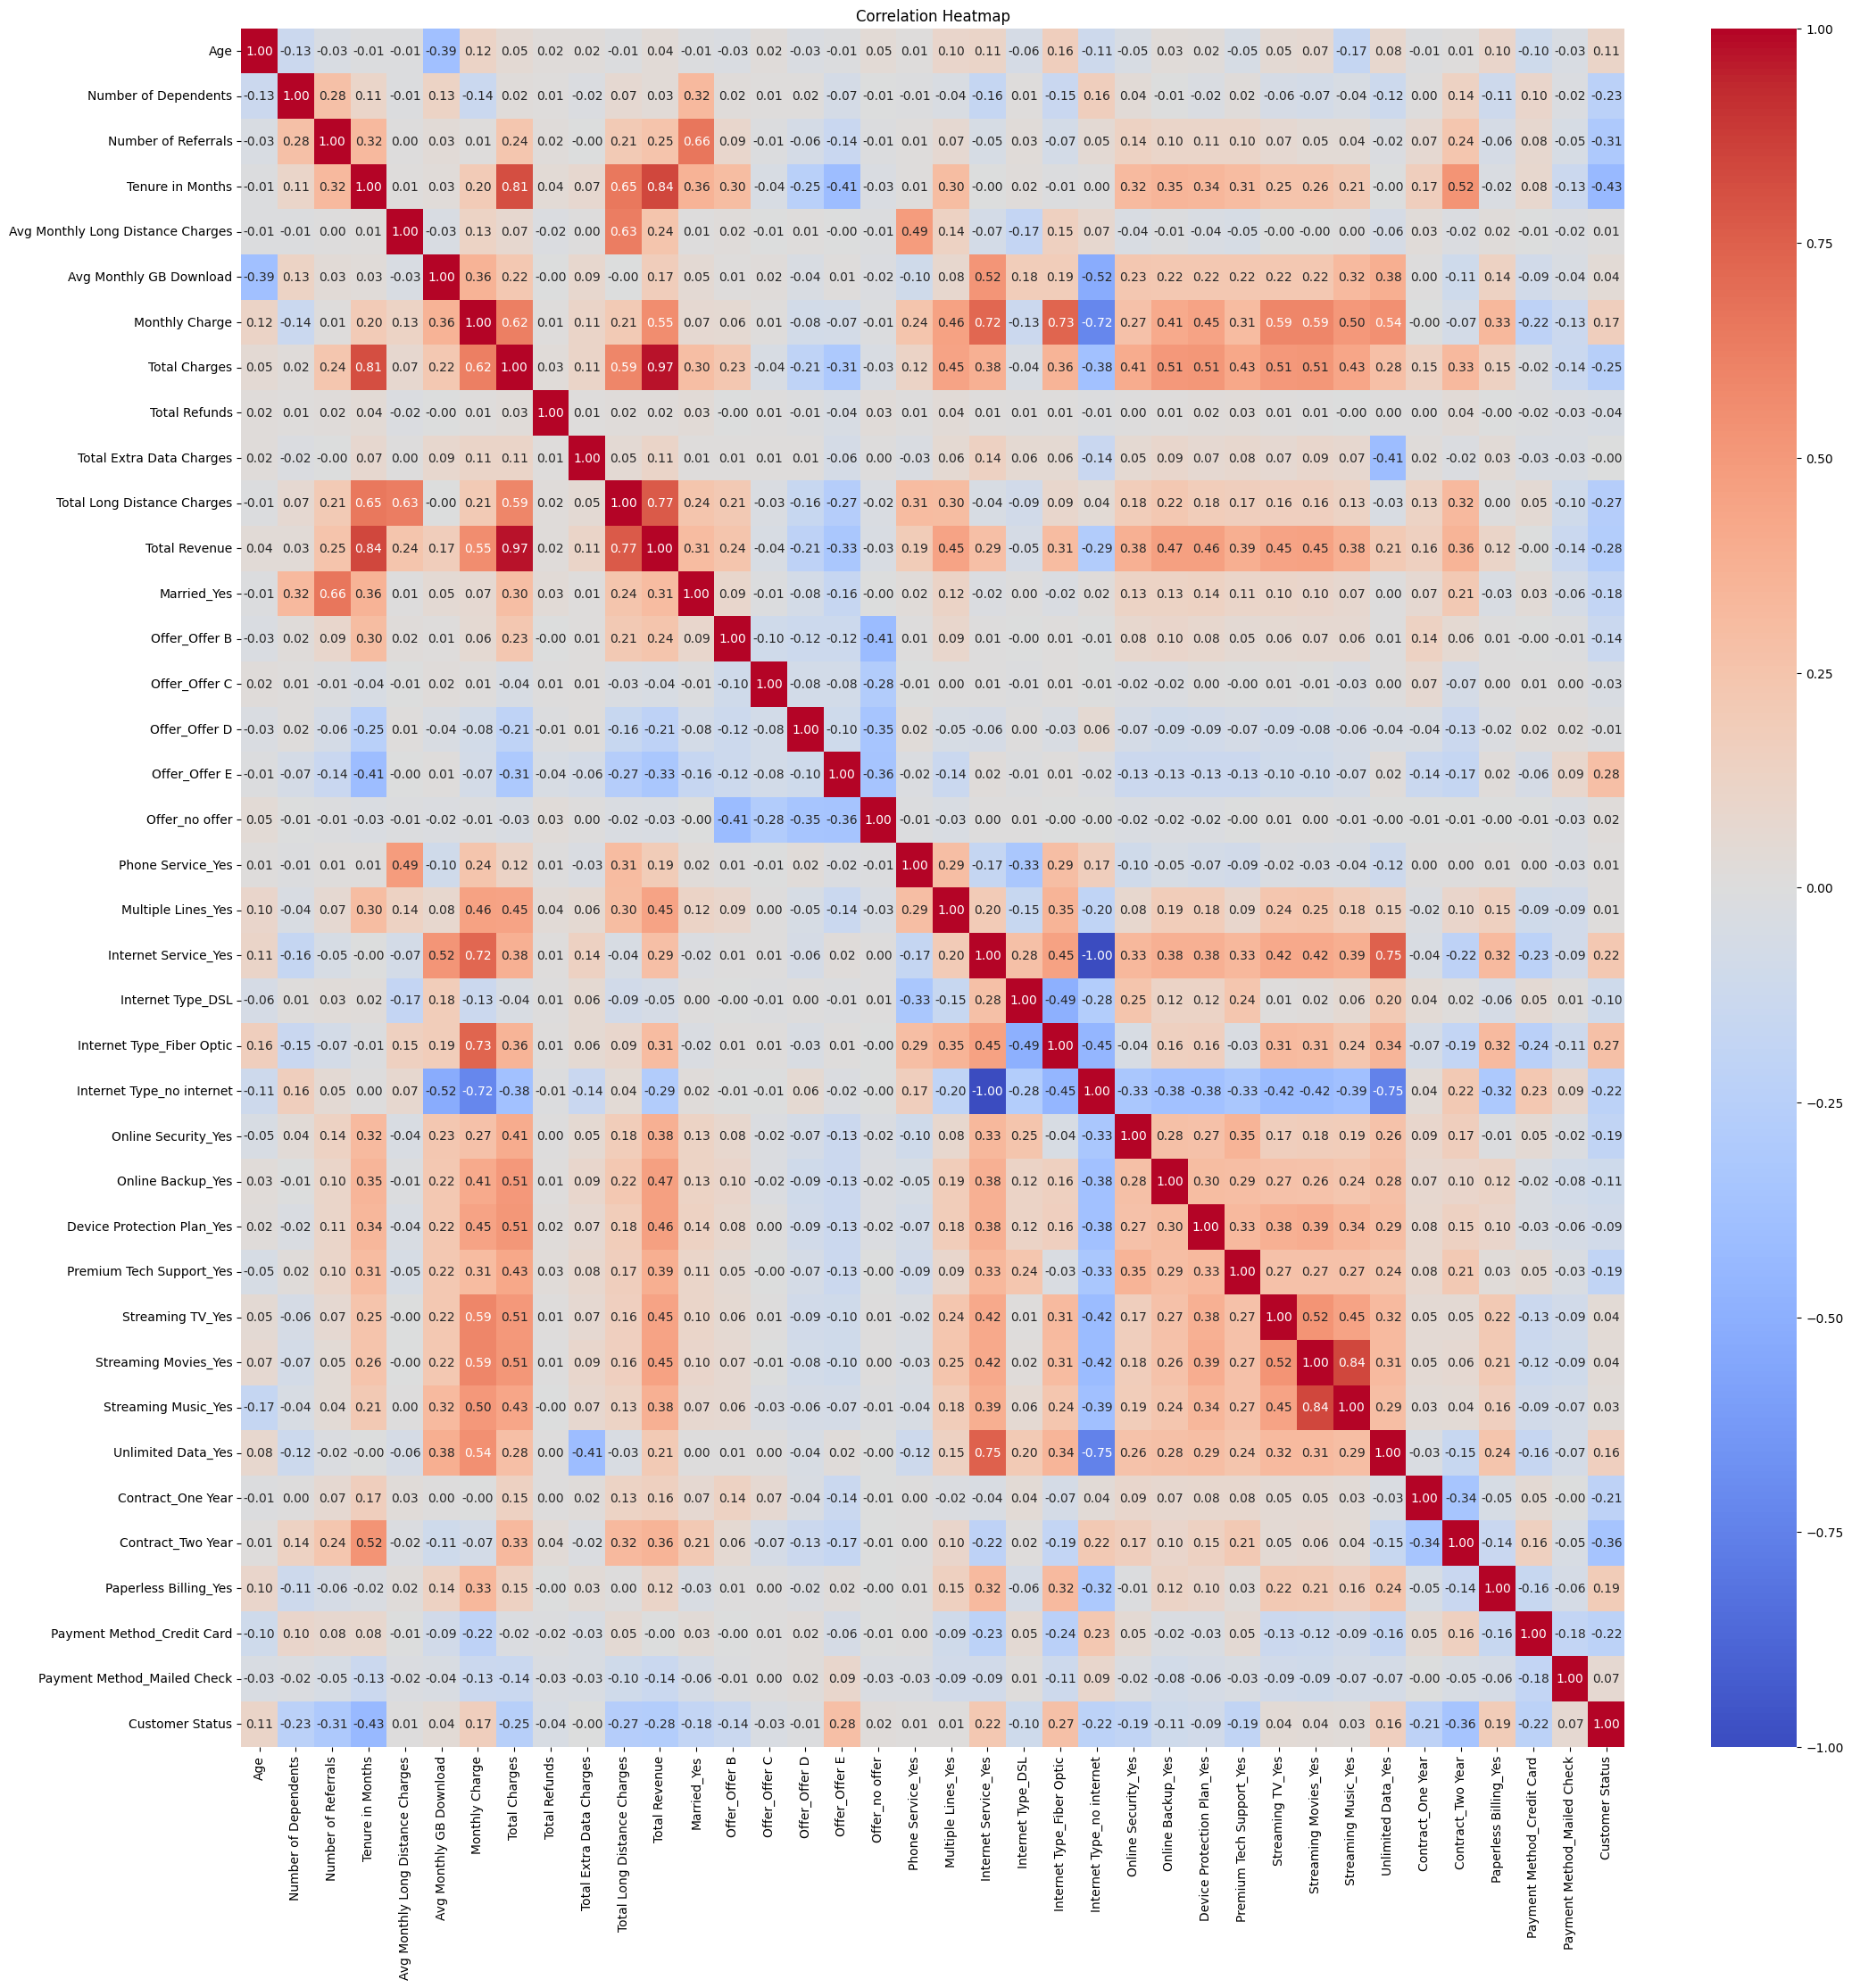

In [13]:
num_df = X.copy()  
df_x_y = pd.concat([num_df, y], axis=1)
correlation_matrix = df_x_y.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

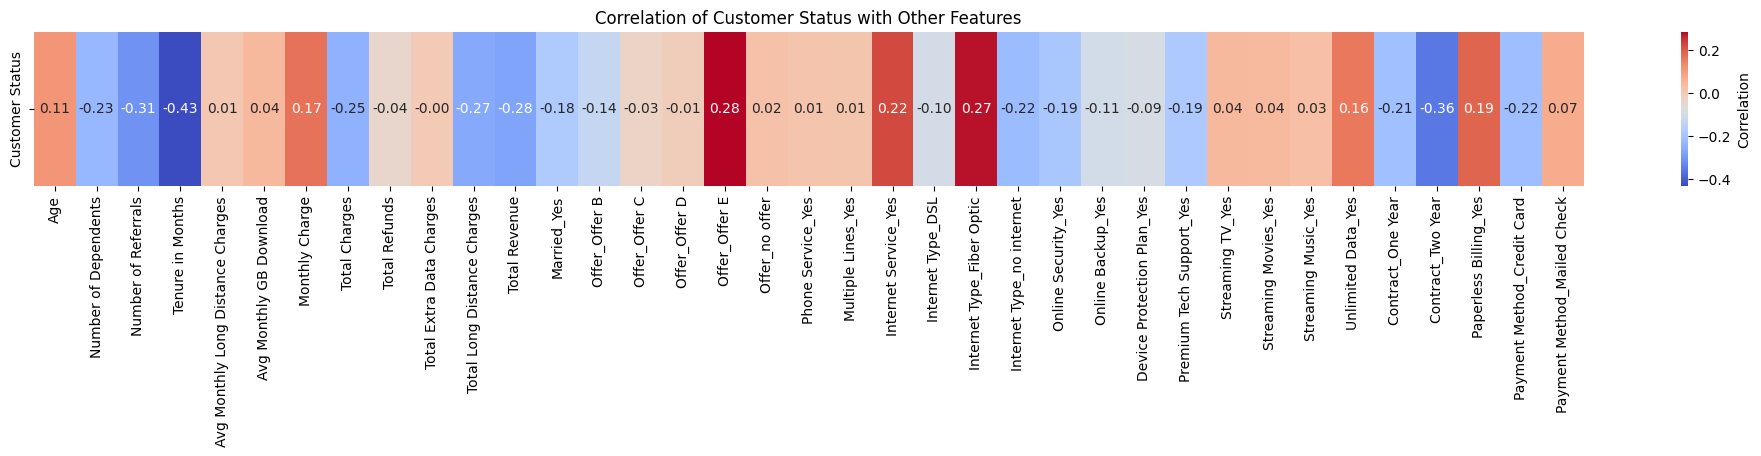

In [14]:
num_df = X.copy() 

df_x_y = pd.concat([num_df, y], axis=1)

correlation_matrix = df_x_y.corr()

customer_status_corr = correlation_matrix.loc['Customer Status'].drop('Customer Status')  

plt.figure(figsize=(25, 2))
sns.heatmap(customer_status_corr.to_frame().T, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation'})
plt.title('Correlation of Customer Status with Other Features')

plt.show()

In [15]:
df.describe()

Age  Number of Dependents  Number of Referrals  \
count  6589.000000           6589.000000          6589.000000   
mean     46.760510              0.476097             2.020944   
std      16.841362              0.968499             3.024016   
min      19.000000              0.000000             0.000000   
25%      33.000000              0.000000             0.000000   
50%      46.000000              0.000000             0.000000   
75%      60.000000              0.000000             3.000000   
max      80.000000              9.000000            11.000000   

       Tenure in Months  Avg Monthly Long Distance Charges  \
count       6589.000000                        6589.000000   
mean          34.499772                          23.004277   
std           23.968734                          15.466844   
min            1.000000                           0.000000   
25%           12.000000                           9.250000   
50%           32.000000                          22.920000   
75%           57.000000                          36.440000   
max           72.000000                          49.990000   

       Avg Monthly GB Download  Monthly Charge  Total Charges  Total Refunds  \
count              6589.000000     6589.000000    6589.000000    6589.000000   
mean                 20.876461       65.030695    2432.042243       2.080938   
std                  20.406247       31.100727    2265.500080       8.125054   
min                   0.000000      -10.000000      18.850000       0.000000   
25%                   4.000000       35.800000     544.550000       0.000000   
50%                  17.000000       71.050000    1563.900000       0.000000   
75%                  27.000000       90.400000    4003.000000       0.000000   
max                  85.000000      118.750000    8684.800000      49.790000   

       Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
count               6589.000000                  6589.000000    6589.000000   
mean                   7.169525                   798.087251    3235.218082   
std                   25.803163                   853.767972    2854.600036   
min                    0.000000                     0.000000      21.610000   
25%                    0.000000                   106.680000     835.450000   
50%                    0.000000                   472.680000    2376.450000   
75%                    0.000000                  1275.120000    5106.640000   
max                  150.000000                  3564.720000   11979.340000   

       Customer Status  
count      6589.000000  
mean          0.283655  
std           0.450805  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000

## ML with out scaling

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf= GradientBoostingClassifier(random_state=0,max_depth=3)
clf.fit(X_train, y_train)

print('Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf.score(X_test, y_test)))

cm = confusion_matrix(y_test, clf.predict(X_test))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf.predict(X_test))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.89
Accuracy on test set: 0.88

Confusion Matrix:
 [[1128   77]
 [ 122  321]]
Recall: 0.72


In [17]:
class_weights = {0: 1, 1: 2}  
sample_weights = y_train.map(class_weights)
clf_ = GradientBoostingClassifier(random_state=0)
clf_.fit(X_train, y_train, sample_weight=sample_weights)

print('Accuracy on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf.score(X_test, y_test)))

cm = confusion_matrix(y_test, clf_.predict(X_test))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf_.predict(X_test))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.89
Accuracy on test set: 0.88

Confusion Matrix:
 [[1047  158]
 [  75  368]]
Recall: 0.83


In [18]:
class_weights = {0: 1, 1: 2} 

clf1 = RandomForestClassifier(random_state=0,class_weight='balanced')
clf1.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(clf1.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(clf1.score(X_test, y_test)))

cm = confusion_matrix(y_test, clf1.predict(X_test))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf1.predict(X_test))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 1.00
Accuracy on test set: 0.87
Confusion Matrix:
 [[1131   74]
 [ 135  308]]
Recall: 0.70


In [19]:
from sklearn.linear_model import LogisticRegression

clf2 = LogisticRegression(C=100).fit(X_train, y_train)
print('Accuracy on training set: {:.2f}'.format(clf2.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf2.score(X_test, y_test)))

cm = confusion_matrix(y_test, clf2.predict(X_test))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf2.predict(X_test))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.81
Accuracy on test set: 0.83

Confusion Matrix:
 [[1086  119]
 [ 166  277]]
Recall: 0.63


C:\Users\Moussab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## ML using MinMaxScaler

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf3 = MLPClassifier(hidden_layer_sizes = [10,10,10], alpha = 5,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Accuracy on training set: {:.2f}'.format(clf3.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf3.score(X_test_scaled, y_test)))

cm = confusion_matrix(y_test, clf3.predict(X_test_scaled))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf3.predict(X_test_scaled))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.89
Accuracy on test set: 0.87

Confusion Matrix:
 [[1103  102]
 [ 110  333]]
Recall: 0.75


C:\Users\Moussab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [21]:
clf2_ = LogisticRegression(C=100).fit(X_train_scaled, y_train)
print('Accuracy on training set: {:.2f}'.format(clf2_.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf2_.score(X_test_scaled, y_test)))

cm = confusion_matrix(y_test, clf2_.predict(X_test_scaled))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf2_.predict(X_test_scaled))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.86
Accuracy on test set: 0.85

Confusion Matrix:
 [[1075  130]
 [ 115  328]]
Recall: 0.74


In [22]:
from sklearn.svm import LinearSVC

clf4 = LinearSVC().fit(X_train_scaled, y_train)
print('Accuracy on training set: {:.2f}'.format(clf4.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf4.score(X_test_scaled, y_test)))

cm = confusion_matrix(y_test, clf4.predict(X_test_scaled))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf4.predict(X_test_scaled))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.85
Accuracy on test set: 0.85

Confusion Matrix:
 [[1076  129]
 [ 114  329]]
Recall: 0.74


In [23]:
clf4 = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print('Accuracy on training set: {:.2f}'.format(clf4.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}\n'.format(clf4.score(X_test_scaled, y_test)))

cm = confusion_matrix(y_test, clf4.predict(X_test_scaled))
print("Confusion Matrix:\n", cm)

recall = recall_score(y_test, clf4.predict(X_test_scaled))
print(f"Recall: {recall:.2f}")

Accuracy on training set: 0.88
Accuracy on test set: 0.85

Confusion Matrix:
 [[1078  127]
 [ 115  328]]
Recall: 0.74
